# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.WARNING)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']

import pyaldata as pyal
import defs

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(dt)
    reload(defs)
    reload(params)
finally:
    os.chdir(nbPath)

# reading data

In [2]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

# Check the duration of reach and pull

In [3]:
if "__file__" not in dir():

    def reach_phase_len(df):
        keys = np.unique(df.target_id)
        out = {key:[] for key in keys}
        for i, traj in enumerate(df.hTrjB):
            a = traj[df.idx_movement_on[i]:df.idx_pull_on[i],0]
            cleanTraj = a[np.logical_not(np.isnan(a))]
            out[df.target_id[i]].append(len(cleanTraj) * df.bin_size[i])

        return out

    def pull_phase_len(df):
        keys = np.unique(df.target_id)
        out = {key:[] for key in keys}
        for i, traj in enumerate(df.hTrjB):
            a = traj[df.idx_pull_on[i]:df.idx_pull_off[i],0]
            cleanTraj = a[np.logical_not(np.isnan(a))]
            out[df.target_id[i]].append(len(cleanTraj) * df.bin_size[i])

        return out

    def trial_len(df):
        keys = np.unique(df.target_id)
        out = {key:[] for key in keys}
        for i, traj in enumerate(df.hTrjB):
            a = traj[df.idx_movement_on[i]:df.idx_pull_off[i],0]
            cleanTraj = a[np.logical_not(np.isnan(a))]
            out[df.target_id[i]].append(len(cleanTraj) * df.bin_size[i])

        return out

plot the duration of pull and reach

Text(0.09, 0.5, 'Different datasets')

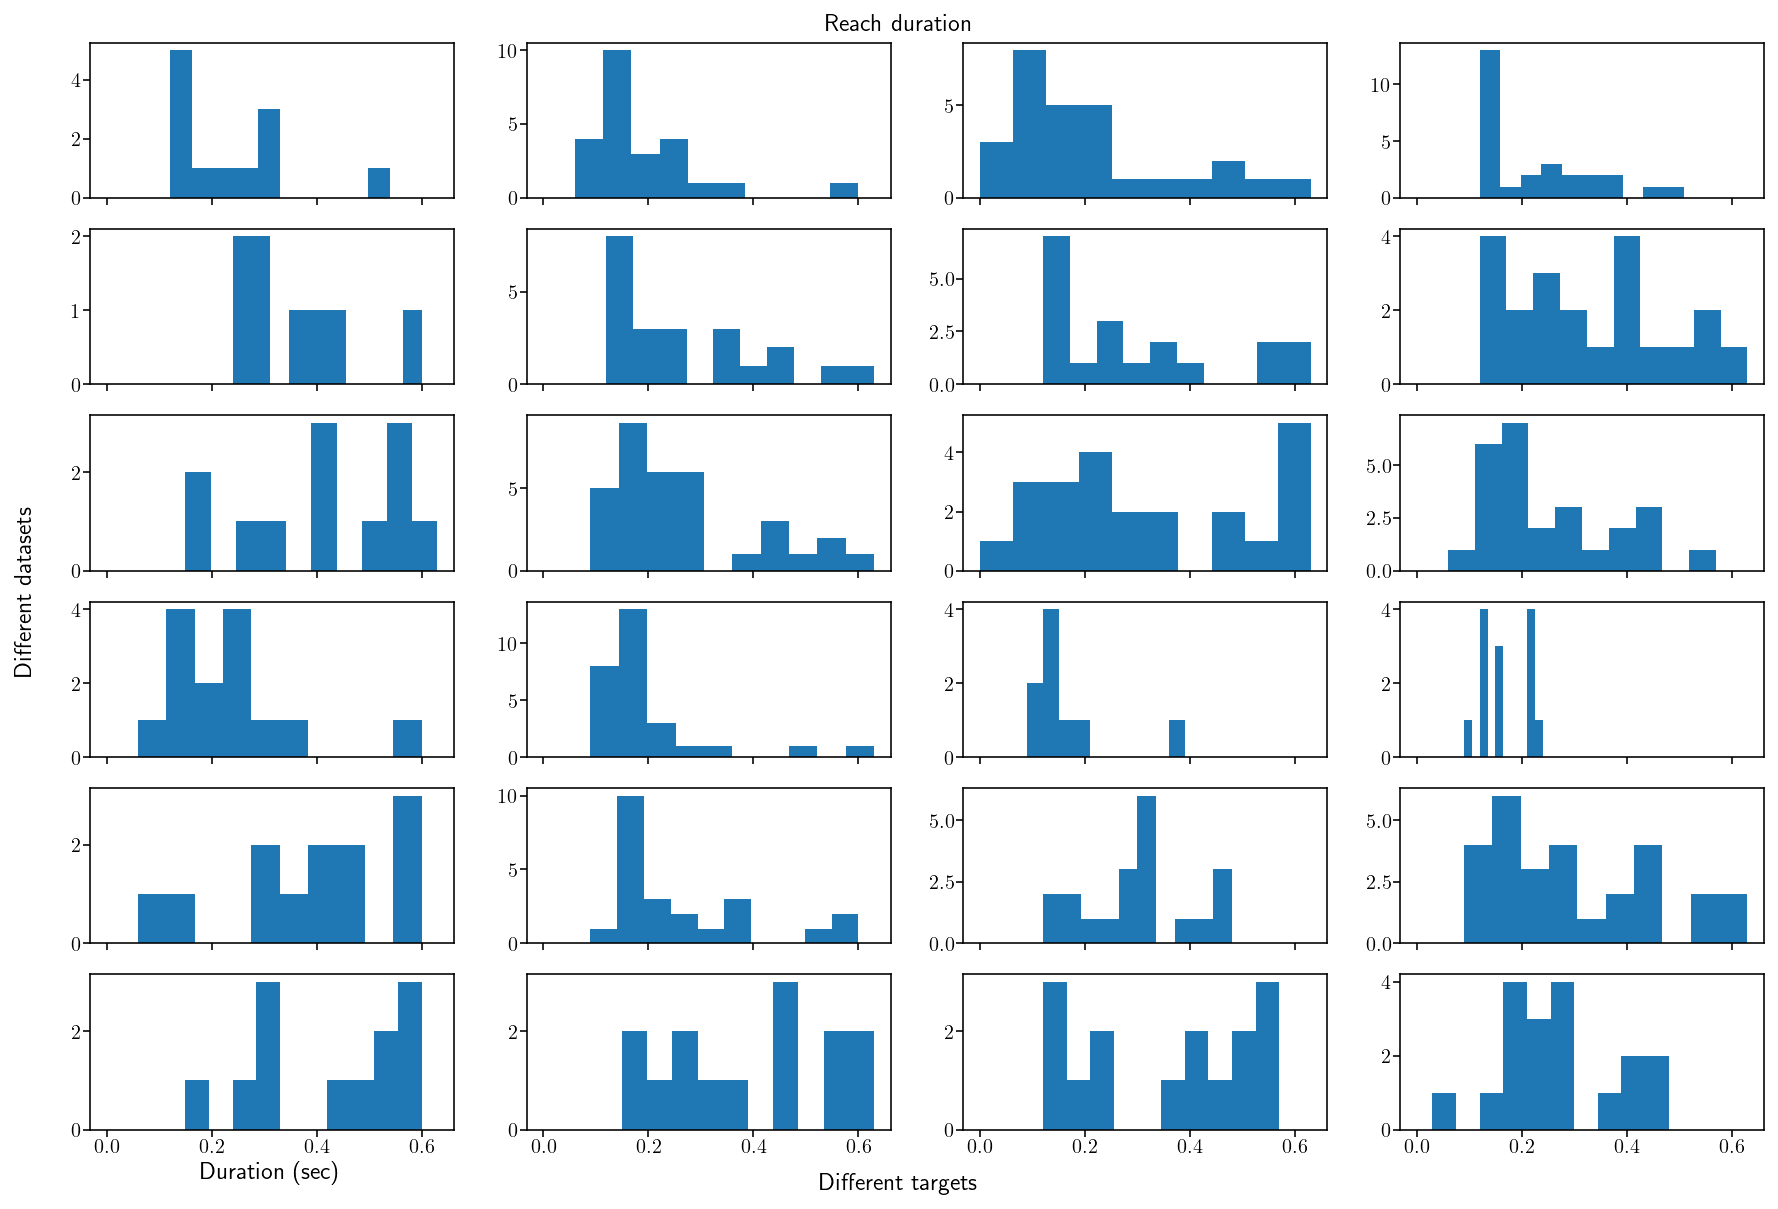

In [5]:
if "__file__" not in dir():

    fig,axes = plt.subplots(len(AllDFs),len(np.unique(df.target_id)),figsize=(15,10), sharex=True)


    for row,df in enumerate(AllDFs):
        a = reach_phase_len(df)
        for col, data in a.items():
            axes[row,col].hist(np.array(data))
    fig.suptitle('Reach duration', y=0.9);
    axes[-1,0].set_xlabel('Duration (sec)')
    fig.supxlabel('Different targets', y=.08)
    fig.supylabel('Different datasets', x=.09)

Text(0.09, 0.5, 'Different datasets')

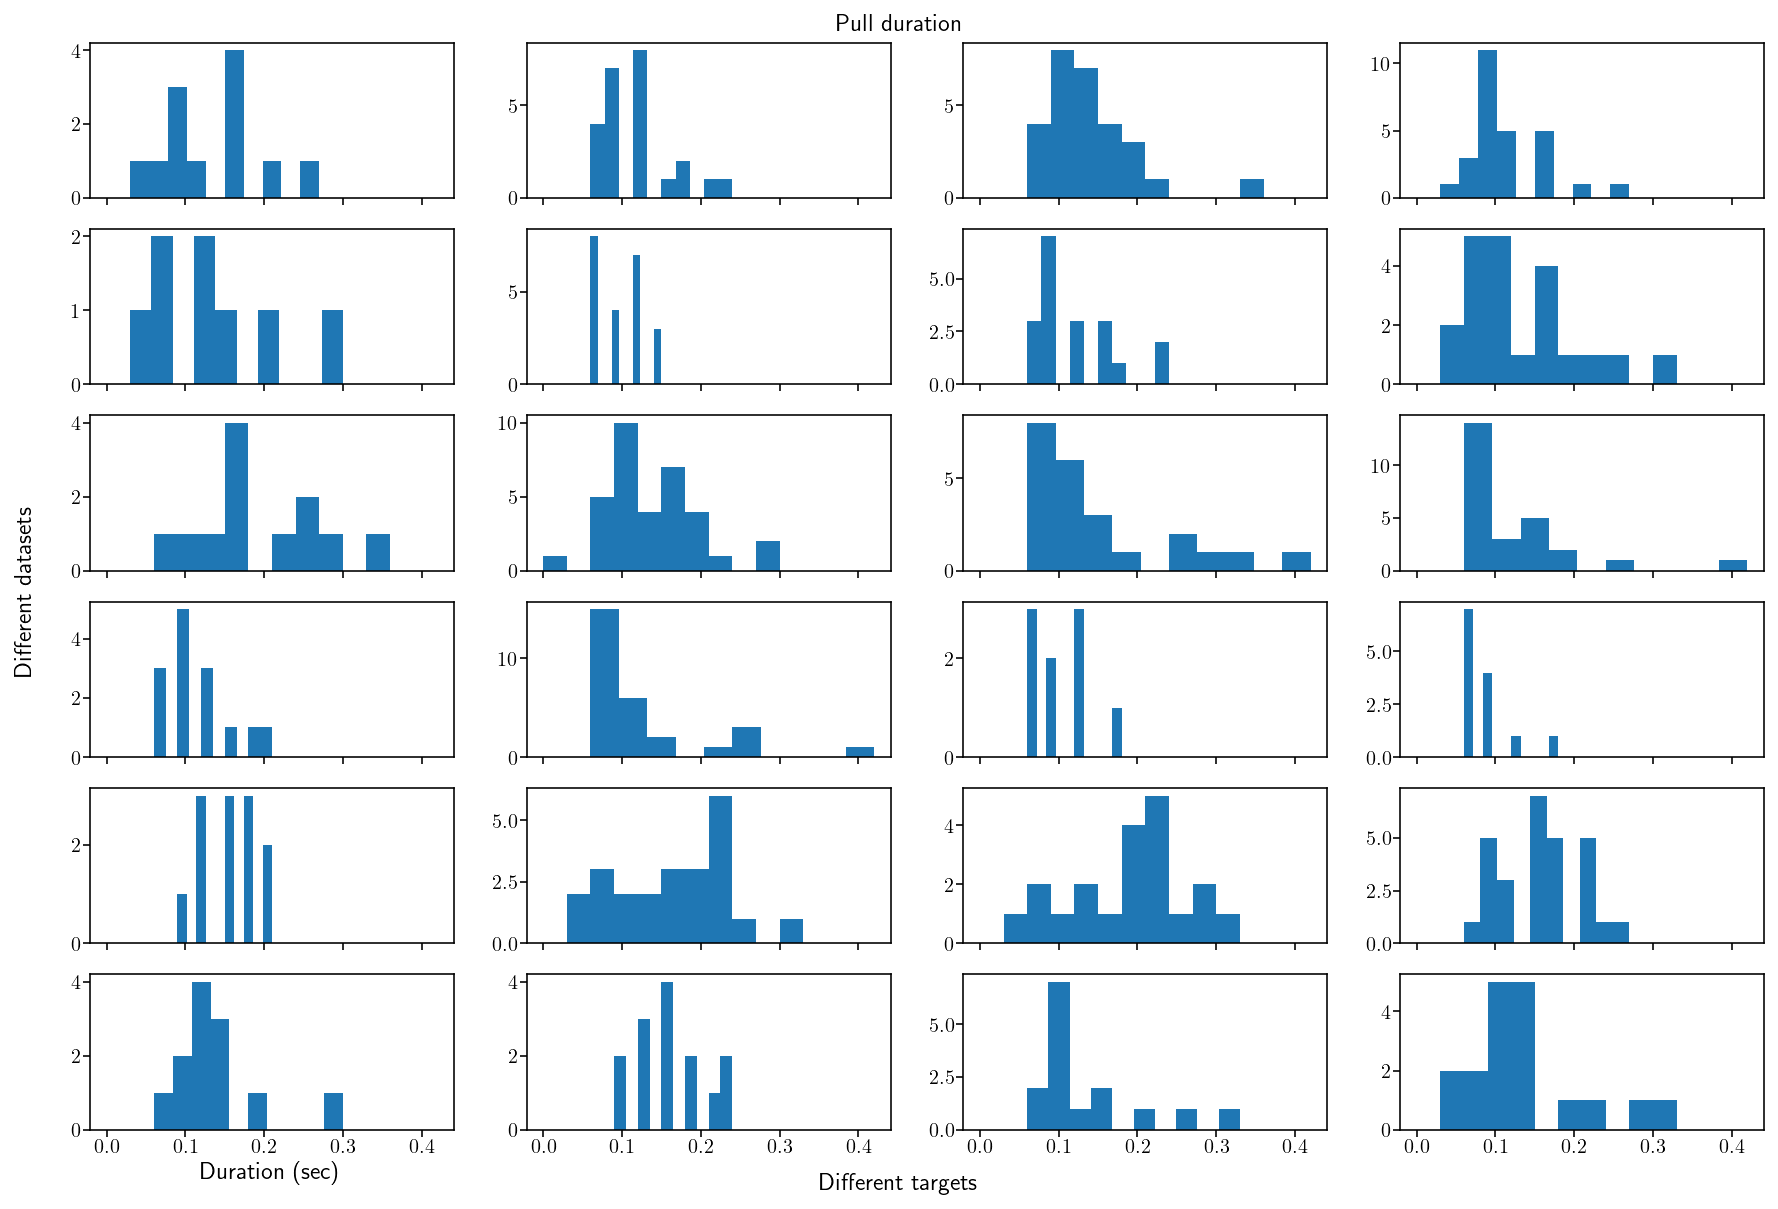

In [6]:
if "__file__" not in dir():

    fig,axes = plt.subplots(len(AllDFs),len(np.unique(df.target_id)),figsize=(15,10), sharex=True)


    for row,df in enumerate(AllDFs):
        a = pull_phase_len(df)
        for col, data in a.items():
            axes[row,col].hist(np.array(data))
    fig.suptitle('Pull duration', y=0.9);
    axes[-1,0].set_xlabel('Duration (sec)')
    fig.supxlabel('Different targets', y=.08)
    fig.supylabel('Different datasets', x=.09)

Text(0.09, 0.5, 'Different datasets')

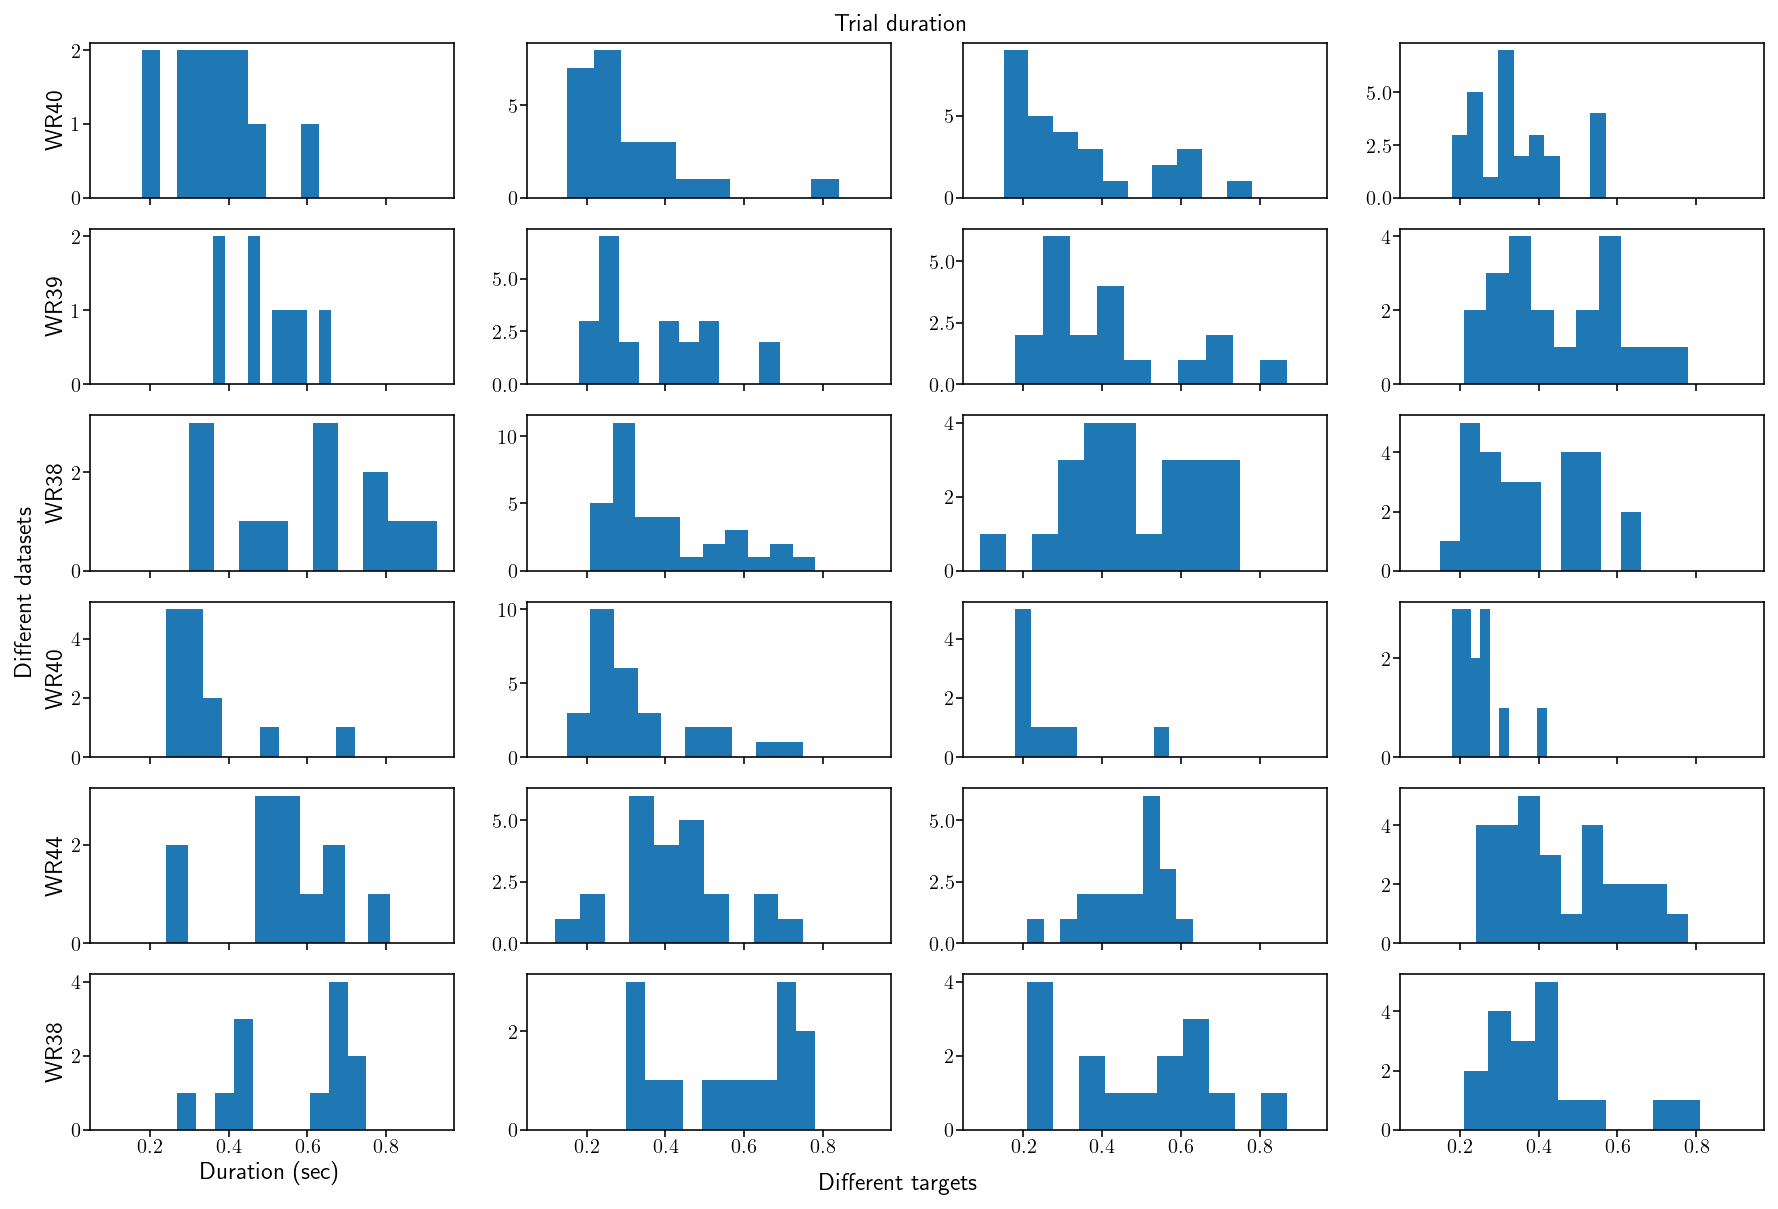

In [7]:
if "__file__" not in dir():

    fig,axes = plt.subplots(len(AllDFs),len(np.unique(df.target_id)),figsize=(15,10), sharex=True)


    for row,df in enumerate(AllDFs):
        a = trial_len(df)
        for col, data in a.items():
            axes[row,col].hist(np.array(data))
        axes[row,0].set_ylabel(df.mouse[0])
    fig.suptitle('Trial duration', y=0.9);
    axes[-1,0].set_xlabel('Duration (sec)')
    fig.supxlabel('Different targets', y=.08)
    fig.supylabel('Different datasets', x=.09)

# Behavioural Correlations

Correlate behaviour during the trial  
To **all** traget

---

## Correaltions to the **same** target

with time warping

In [4]:
if "__file__" not in dir():

    within_corrs = {}
    within_good = within_bad = 0
    for df in AllDFs:
        within_corrs[df.file[0]] = []
        targets = np.unique(df.target_id)
        for target in targets:
            df_ = pyal.select_trials(df, df.target_id == target)
            for i, vel1 in enumerate(df_.hVelB):
                a = vel1[df_.idx_movement_on[i]:df_.idx_pull_off[i],:]
                for j, vel2 in enumerate(df_.hVelB):
                    if j<=i: continue
                    b = vel2[df_.idx_movement_on[j]:df_.idx_pull_off[j],:]
                    if abs(len(b) - len(a)) > min((len(b) , len(a))):
    #                     logging.warning(f'mismatching trial pair dropeed: {len(a)=},{len(b)=}')
                        within_bad +=1
                        continue
                    a_,b_ = dt.warp_time(a,b)
                    r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                    within_corrs[df_.file[0]].append(np.mean(np.abs(r)))
                    within_good +=1


    across_corrs = {}
    across_good = across_bad = 0
    for dfi, df1 in enumerate(AllDFs):
        targets = np.unique(df1.target_id)
        across_corrs[df1.file[0]]={}
        for dfj, df2 in enumerate(AllDFs):
            if dfj <= dfi: continue
            across_corrs[df1.file[0]][df2.file[0]]=[]
            for target in targets:
                df1_ = pyal.select_trials(df1, df1.target_id == target)
                df2_ = pyal.select_trials(df2, df2.target_id == target)
                for i, vel1 in enumerate(df1_.hVelB):
                    a = vel1[df1_.idx_movement_on[i]:df1_.idx_pull_off[i],:]
                    for j, vel2 in enumerate(df2_.hVelB):
                        b = vel2[df2_.idx_movement_on[j]:df2_.idx_pull_off[j],:]
                        if abs(len(b) - len(a)) > min((len(b) , len(a))):
    #                         logging.warning(f'mismatching trial pair dropeed: {len(a)=},{len(b)=}')
                            across_bad +=1
                            continue
                        a_,b_ = dt.warp_time(a,b)
                        r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                        across_corrs[df1_.file[0]][df2_.file[0]].append(np.mean(np.abs(r)))
                        across_good +=1

if "__file__" not in dir():
    print(f'percent pairs rejected: {within_bad/(within_good+within_bad)*100:2.0f}% within, \
    {across_bad/(across_good+across_bad)*100:2.0f}% across.')
# clear_output()

percent pairs rejected: 19% within,     25% across.


In [5]:
if "__file__" not in dir():

    fig,axes = plt.subplots(len(AllDFs),len(AllDFs),figsize=(10,10))

    for i, df1 in enumerate(AllDFs):
        for j, df2 in enumerate(AllDFs):
            if j<=i:
                utility.phantom_axes(axes[i,j])
                continue
            ax = axes[i,j]
            ax.hist(across_corrs[df1.file[0]][df2.file[0]],alpha=.8,color='r',label='across $i$ \& $j$')
            ax.hist(within_corrs[df1.file[0]],alpha=.5,color='b',label='within $i$')
            ax.hist(within_corrs[df2.file[0]],alpha=.5,color='b',label='within $j$')
            ax.text(.5,.9,f'$\mu = {np.mean(across_corrs[df1.file[0]][df2.file[0]]):0.2f}$', ha='center',fontsize='medium',transform=ax.transAxes)
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xlim([0,1])
            ax.set_xticks([0,1])

    [fig.delaxes(ax) for ax in axes[-1,:]]
    axes[0,1].legend(bbox_to_anchor=(0,.5),loc=7)
    axes[-2,-1].set_xlabel(r"Pearson's $r$", labelpad=-6);
    fig.supylabel('Different sessions', x=.92)
    fig.suptitle('Velocity correlations',y=.9,fontsize='x-large');

### without time warping

trimming the trials to the same length

In [6]:
def trim_within_mouse_corr(allDF:list[pd.DataFrame],):
    trim_within_corrs = {}
    within_good = within_bad = 0
    for df in allDF:
        trim_within_corrs[df.file[0]] = []
        targets = np.unique(df.target_id)
        for target in targets:
            df_ = pyal.select_trials(df, df.target_id == target)
            for i, vel1 in enumerate(df_.hVelB):
                a = vel1[df_.idx_movement_on[i]:df_.idx_pull_off[i],:]
                for j, vel2 in enumerate(df_.hVelB):
                    if j<=i: continue
                    b = vel2[df_.idx_movement_on[j]:df_.idx_pull_off[j],:]
                    if abs(len(b) - len(a)) > min((len(b) , len(a))):
                        within_bad += 1
                        continue
                    a_,b_ = defs.time_trim(a,b)
                    r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                    trim_within_corrs[df_.file[0]].append(np.mean(np.abs(r)))
                    within_good += 1

    logging.warning(f'mismatching within trial pair dropeed: {within_bad/(within_good+within_bad)*100:2.0f}%')
    return trim_within_corrs


def trim_across_mouse_corr(allDF:list[pd.DataFrame],):
    trim_across_corrs = {}
    across_good = across_bad = 0
    for dfi, df1 in enumerate(allDF):
        targets = np.unique(df1.target_id)
        trim_across_corrs[df1.file[0]]={}
        for dfj, df2 in enumerate(allDF):
            trim_across_corrs[df2.file[0]] = {} if df2.file[0] not in trim_across_corrs.keys() else trim_across_corrs[df2.file[0]]
            if dfj <= dfi: continue
            trim_across_corrs[df1.file[0]][df2.file[0]]=[]
            for target in targets:
                df1_ = pyal.select_trials(df1, df1.target_id == target)
                df2_ = pyal.select_trials(df2, df2.target_id == target)
                for i, vel1 in enumerate(df1_.hVelB):
                    a = vel1[df1_.idx_movement_on[i]:df1_.idx_pull_off[i],:]
                    for j, vel2 in enumerate(df2_.hVelB):
                        b = vel2[df2_.idx_movement_on[j]:df2_.idx_pull_off[j],:]
                        if abs(len(b) - len(a)) > min((len(b) , len(a))):
                            across_bad += 1
                            continue
                        a_,b_ = defs.time_trim(a,b)
                        r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                        trim_across_corrs[df1_.file[0]][df2_.file[0]].append(np.mean(np.abs(r)))
                        across_good += 1

        # make the across correlations symmetrical!
        for  df2_file, val in trim_across_corrs[df1_.file[0]].items():
            trim_across_corrs[df2_file][df1_.file[0]] = val

    logging.warning(f'mismatching across trial pair dropeed: {across_bad/(across_good+across_bad)*100:2.0f}%')
    return trim_across_corrs

In [7]:
if "__file__" not in dir():
    within_corrs = trim_within_mouse_corr (AllDFs)
    across_corrs = trim_across_mouse_corr (AllDFs)

    fig,axes = plt.subplots(len(AllDFs),len(AllDFs),figsize=(10,10))

    for i, df1 in enumerate(AllDFs):
        for j, df2 in enumerate(AllDFs):
            if j<=i:
                utility.phantom_axes(axes[i,j])
                continue
            ax = axes[i,j]
            ax.hist(across_corrs[df1.file[0]][df2.file[0]],alpha=.8,color='r',label=r'across $i$ \& $j$')
            ax.hist(within_corrs[df1.file[0]],alpha=.5,color='b',label='within $i$')
            ax.hist(within_corrs[df2.file[0]],alpha=.5,color='b',label='within $j$')
            ax.text(.5,.9,f'$\mu = {np.mean(across_corrs[df1.file[0]][df2.file[0]]):0.2f}$', ha='center',fontsize='medium',transform=ax.transAxes)
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xlim([0,1])
            ax.set_xticks([0,1])

    [fig.delaxes(ax) for ax in axes[-1,:]]
    axes[0,1].legend(bbox_to_anchor=(0,.5),loc=7)
    axes[-2,-1].set_xlabel(r"Pearson's $r$", labelpad=-6);
    fig.supylabel('Different sessions', x=.92)
    fig.suptitle('Velocity correlations',y=.9,fontsize='x-large');

## Time-warped correlation for Trajectories

as opposed to velocities

In [8]:
if "__file__" not in dir():

    traj_within_corrs = {}
    within_good = within_bad = 0
    for df in AllDFs:
        traj_within_corrs[df.file[0]] = []
        targets = np.unique(df.target_id)
        for target in targets:
            df_ = pyal.select_trials(df, df.target_id == target)
            for i, vel1 in enumerate(df_.hTrjB):
                a = vel1[df_.idx_movement_on[i]:df_.idx_pull_off[i],:]
                for j, vel2 in enumerate(df_.hTrjB):
                    if j<=i: continue
                    b = vel2[df_.idx_movement_on[j]:df_.idx_pull_off[j],:]
                    if abs(len(b) - len(a)) > min((len(b) , len(a))):
    #                     logging.warning(f'mismatching trial pair dropeed: {len(a)=},{len(b)=}')
                        within_bad += 1
                        continue
                    a_,b_ = dt.warp_time(a,b)
                    r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                    traj_within_corrs[df_.file[0]].append(np.mean(np.abs(r)))
                    within_good += 1


    traj_across_corrs = {}
    across_good = across_bad = 0
    for dfi, df1 in enumerate(AllDFs):
        targets = np.unique(df1.target_id)
        traj_across_corrs[df1.file[0]]={}
        for dfj, df2 in enumerate(AllDFs):
            if dfj <= dfi: continue
            traj_across_corrs[df1.file[0]][df2.file[0]]=[]
            for target in targets:
                df1_ = pyal.select_trials(df1, df1.target_id == target)
                df2_ = pyal.select_trials(df2, df2.target_id == target)
                for i, vel1 in enumerate(df1_.hTrjB):
                    a = vel1[df1_.idx_movement_on[i]:df1_.idx_pull_off[i],:]
                    for j, vel2 in enumerate(df2_.hTrjB):
                        b = vel2[df2_.idx_movement_on[j]:df2_.idx_pull_off[j],:]
                        if abs(len(b) - len(a)) > min((len(b) , len(a))):
    #                         logging.warning(f'mismatching trial pair dropeed: {len(a)=},{len(b)=}')
                            across_bad += 1
                            continue
                        a_,b_ = dt.warp_time(a,b)
                        r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                        traj_across_corrs[df1_.file[0]][df2_.file[0]].append(np.mean(np.abs(r)))
                        across_good += 1

                    
if "__file__" not in dir():
    print(f'percent pairs rejected: {within_bad/(within_good+within_bad)*100:2.0f}% within, \
    {across_bad/(across_good+across_bad)*100:2.0f}% across.')
# clear_output()

percent pairs rejected: 19% within,     25% across.


In [9]:
if "__file__" not in dir():

    fig,axes = plt.subplots(len(AllDFs),len(AllDFs),figsize=(10,10))

    for i, df1 in enumerate(AllDFs):
        for j, df2 in enumerate(AllDFs):
            if j<=i:
                utility.phantom_axes(axes[i,j])
                continue
            ax = axes[i,j]
            ax.hist(traj_across_corrs[df1.file[0]][df2.file[0]],alpha=.8,color='r',label='across $i$ \& $j$')
            ax.hist(traj_within_corrs[df1.file[0]],alpha=.5,color='b',label='within $i$')
            ax.hist(traj_within_corrs[df2.file[0]],alpha=.5,color='b',label='within $j$')
            ax.text(.5,.9,f'$\mu = {np.mean(across_corrs[df1.file[0]][df2.file[0]]):0.2f}$', ha='center',fontsize='medium',transform=ax.transAxes)
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xlim([0,1])
            ax.set_xticks([0,1])

    [fig.delaxes(ax) for ax in axes[-1,:]]
    axes[0,1].legend(bbox_to_anchor=(0,.5),loc=7)
    axes[-2,-1].set_xlabel(r"Pearson's $r$", labelpad=-6);
    fig.supylabel('Different sessions', x=.92)
    fig.suptitle('Trajectory correlations',y=.95,fontsize='x-large');

---

# bad

## without separating the targets 

not to be taken seriously! Move on to next cell

In [ ]:
if "__file__" not in dir():

    within_corrs = {}
    for df in AllDFs:
        within_corrs[df.file[0]] = np.zeros((df.shape[0],df.shape[0]))
        for i, vel1 in enumerate(df.hVelB):
            a = vel1[df.idx_movement_on[i]:df.idx_pull_off[i],:]
            for j, vel2 in enumerate(df.hVelB):
                if j<i: continue
                b = vel2[df.idx_movement_on[j]:df.idx_pull_off[j],:]
                a_,b_ = dt.warp_time(a,b)
                r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                within_corrs[df.file[0]][i,j] = np.mean(np.abs(r))
        within_corrs[df.file[0]][within_corrs[df.file[0]]==0] = np.nan
        within_corrs[df.file[0]][within_corrs[df.file[0]]==1] = np.nan

In [ ]:
if "__file__" not in dir():

    fig,axes = plt.subplots(len(AllDFs),1,figsize=(5,10))
    cmap = cm.get_cmap('plasma')

    for i, corrs in enumerate(within_corrs.values()):
        axes[i].imshow(corrs.T,aspect='equal', cmap=cmap, vmin=0, vmax=1)
    fig.supylabel('Different Sessions',x=.3)
    fig.suptitle('Within-session velocity correlations',y=.9)
    axes[-1].set_xlabel('trials')
    axes[-1].set_ylabel('trials')
    gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.57, bottom=0.155, right=.59, top=.225)
    cax = fig.add_subplot(gs_c[:])
    fig.colorbar(mappable=cm.ScalarMappable(cmap=cmap),cax=cax)
    cax.yaxis.set_major_locator(MaxNLocator(integer=True))


In [4]:
if "__file__" not in dir():

    across_corrs = {}
    for dfi, df1 in enumerate(AllDFs):
        across_corrs[df1.file[0]]={}
        for dfj, df2 in enumerate(AllDFs):
            if dfj <= dfi: continue
            across_corrs[df1.file[0]][df2.file[0]]=[]
            for i, vel1 in enumerate(df1.hVelB):
                a = vel1[df1.idx_movement_on[i]:df1.idx_pull_off[i],:]
                for j, vel2 in enumerate(df2.hVelB):
                    b = vel2[df2.idx_movement_on[j]:df2.idx_pull_off[j],:]
                    a_,b_ = dt.warp_time(a,b)
                    r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                    across_corrs[df1.file[0]][df2.file[0]].append(np.mean(np.abs(r)))


In [ ]:
if "__file__" not in dir():

    fig,axes = plt.subplots(len(AllDFs),len(AllDFs),figsize=(10,10),)

    for i, df1 in enumerate(AllDFs):
        for j, df2 in enumerate(AllDFs):
            if j<=i:
                utility.phantom_axes(axes[i,j])
                continue
            axes[i,j].hist(across_corrs[df1.file[0]][df2.file[0]],alpha=.8,color='r',label='across $i$ \& $j$')
            axes[i,j].hist(within_corrs[df1.file[0]].flatten(),alpha=.5,color='b',label='within $i$')
            axes[i,j].hist(within_corrs[df2.file[0]].flatten(),alpha=.5,color='b',label='within $j$')
            axes[i,j].set_yticks([])

    [fig.delaxes(ax) for ax in axes[-1,:]]
    axes[0,1].legend(bbox_to_anchor=(0,.5),loc=7)
    axes[-2,-1].set_xlabel(r"Pearson's $r$");